
<h1><center id="title">DataLab Cup 3: Reverse Image Caption</center></h1>

<center id="author">Shan-Hung Wu &amp; DataLab<br/>Fall 2025</center>




<h1><center class="subtitle">Text to Image</center></h1>

<h2 id="Platform:-Kaggle">Platform: <a href="https://www.kaggle.com/competitions/2025-datalab-cup-3-reverse-image-caption/overview">Kaggle</a><a class="anchor-link" href="#Platform:-Kaggle">¶</a></h2>
<h2 id="Overview">Overview<a class="anchor-link" href="#Overview">¶</a></h2>
<p>In this work, we are interested in translating text in the form of single-sentence human-written descriptions directly into image pixels. For example, "<strong>this flower has petals that are yellow and has a ruffled stamen</strong>" and "<strong>this pink and yellow flower has a beautiful yellow center with many stamens</strong>". You have to develop a novel deep architecture and GAN formulation to effectively translate visual concepts from characters to pixels.</p>

<p>More specifically, given a set of texts, your task is to generate reasonable images with size 64x64x3 to illustrate the corresponding texts. Here we use <a href="http://www.robots.ox.ac.uk/~vgg/data/flowers/102/">Oxford-102 flower dataset</a> and its <a href="https://drive.google.com/file/d/0B0ywwgffWnLLcms2WWJQRFNSWXM/view">paired texts</a> as our training dataset.</p>

<img alt="No description has been provided for this image" src="./data/example.png"/>

<ul>
<li>7370 images as training set, where each images is annotated with at most 10 texts.</li>
<li>819 texts for testing. You must generate 1 64x64x3 image for each text.</li>
</ul>




<h2 id="Conditional-GAN">Conditional GAN<a class="anchor-link" href="#Conditional-GAN">¶</a></h2>
<p>Given a text, in order to generate the image which can illustrate it, our model must meet several requirements:</p>

<ol>
<li>Our model should have ability to understand and extract the meaning of given texts.<ul>
<li>Use RNN or other language model, such as BERT, ELMo or XLNet, to capture the meaning of text.</li>
</ul>
</li>
<li>Our model should be able to generate image.<ul>
<li>Use GAN to generate high quality image.</li>
</ul>
</li>
<li>GAN-generated image should illustrate the text.<ul>
<li>Use conditional-GAN to generate image conditioned on given text.</li>
</ul>
</li>
</ol>

<p>Generative adversarial nets can be extended to a conditional model if both the generator and discriminator are conditioned on some extra information $y$. We can perform the conditioning by feeding $y$ into both the discriminator and generator as additional input layer.</p>

<img alt="No description has been provided for this image" src="./data/cGAN.png" width="500"/>

<p>There are two motivations for using some extra information in a GAN model:</p>

<ol>
<li>Improve GAN.</li>
<li>Generate targeted image.</li>
</ol>

<p>Additional information that is correlated with the input images, such as class labels, can be used to improve the GAN. This improvement may come in the form of more stable training, faster training, and/or generated images that have better quality.</p>

<img alt="No description has been provided for this image" src="./data/GANCLS.jpg"/>



In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# BASE_PATH = '/content/drive/MyDrive/DL_datasets/Comp3/'
BASE_PATH = '.'

In [3]:
!pip install matplotlib numpy pandas pillow tqdm transformers

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# os.environ['CUDA_CACHE_DISABLE'] = '0'
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
# os.environ['TF_CUDA_COMPUTE_CAPABILITIES'] = '12.0'
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path
from tqdm import tqdm

import re
from IPython import display

2025-11-30 16:05:12.629993: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 16:05:12.637431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-30 16:05:12.646351: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-30 16:05:12.649081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-30 16:05:12.656607: I tensorflow/core/platform/cpu_feature_guar

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

RANDOM_SEED = 42

# Python random
import random
random.seed(RANDOM_SEED)

# NumPy random
np.random.seed(RANDOM_SEED)

# TensorFlow random
tf.random.set_seed(RANDOM_SEED)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1764518713.932300   14150 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1764518713.975658   14150 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1764518713.977387   14150 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1764518713.980635   14150 cuda_executor.cc:1015] successful NUMA node read from SysFS ha


<h2 id="Preprocess-Text">Preprocess Text<a class="anchor-link" href="#Preprocess-Text">¶</a></h2>
<p>Since dealing with raw string is inefficient, we have done some data preprocessing for you:</p>

<ul>
<li>Delete text over <code>MAX_SEQ_LENGTH (20)</code>.</li>
<li>Delete all puntuation in the texts.</li>
<li>Encode each vocabulary in <code>dictionary/vocab.npy</code>.</li>
<li>Represent texts by a sequence of integer IDs.</li>
<li>Replace rare words by <code>&lt;RARE&gt;</code> token to reduce vocabulary size for more efficient training.</li>
<li>Add padding as <code>&lt;PAD&gt;</code> to each text to make sure all of them have equal length to <code>MAX_SEQ_LENGTH (20)</code>.</li>
</ul>

<p>It is worth knowing that there is no necessary to append <code>&lt;ST&gt;</code> and <code>&lt;ED&gt;</code> to each text because we don't need to generate any sequence in this task.</p>

<p>To make sure correctness of encoding of the original text, we can decode sequence vocabulary IDs by looking up the vocabulary dictionary:</p>

<ul>
<li><code>dictionary/word2Id.npy</code> is a numpy array mapping word to id.</li>
<li><code>dictionary/id2Word.npy</code> is a numpy array mapping id back to word.</li>
</ul>



In [6]:
dictionary_path = BASE_PATH + '/dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

BATCH_SIZE = 4  # Reduced from 8 to avoid OOM

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [7]:
# This cell previously contained sent2IdList() function
# It has been removed as we now use DistilBERT tokenizer instead
# The id2word_dict is still available from cell 6 for visualization purposes

print("✓ Using DistilBERT tokenizer (sent2IdList removed)")

✓ Using DistilBERT tokenizer (sent2IdList removed)



<h2 id="Dataset">Dataset<a class="anchor-link" href="#Dataset">¶</a></h2>
<p>For training, the following files are in dataset folder:</p>

<ul>
<li><code>./dataset/text2ImgData.pkl</code> is a pandas dataframe with attribute 'Captions' and 'ImagePath'.<ul>
<li>'Captions' : A list of text id list contain 1 to 10 captions.</li>
<li>'ImagePath': Image path that store paired image.</li>
</ul>
</li>
<li><code>./102flowers/</code> is the directory containing all training images.</li>
<li><code>./dataset/testData.pkl</code> is a pandas a dataframe with attribute 'ID' and 'Captions', which contains testing data.</li>
</ul>



In [8]:
data_path = BASE_PATH + '/dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [9]:
df.head(5)

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg



<h2 id="Create-Dataset-by-Dataset-API">Create Dataset by Dataset API<a class="anchor-link" href="#Create-Dataset-by-Dataset-API">¶</a></h2>



In [10]:
# IMPORTANT: Import TensorFlow FIRST before transformers
import tensorflow as tf
from transformers import CLIPTokenizer

# Load CLIP Tokenizer
# "openai/clip-vit-base-patch32" is a standard, powerful model
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

def preprocess_text_clip(text, max_length=77):
		encoded = tokenizer(
				text,
				padding='max_length',
				truncation=True,
				max_length=max_length,
				return_tensors='tf'
		)
		return {
				'input_ids': encoded['input_ids'],
				'attention_mask': encoded['attention_mask']
		}

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def DiffAugment(x, policy='color,translation,cutout', channels_first=False, params=None):
    """
    Differentiable augmentation for GANs

    Args:
        x: Input images [batch, H, W, C]
        policy: Comma-separated augmentation policies
        channels_first: If True, expects [batch, C, H, W]
        params: Optional dict of pre-generated augmentation parameters for consistency

    Returns:
        Augmented images (clipped to [0, 1] range)
    """
    if policy:
        if not channels_first:
            # TensorFlow format: [batch, H, W, C]
            for p in policy.split(','):
                for f in AUGMENT_FNS[p]:
                    x = f(x, params)  # ← Pass params!
    return x


def rand_brightness(x, params=None):
    """Random brightness adjustment"""
    if params is not None and 'brightness' in params:
        magnitude = params['brightness']
    else:
        magnitude = tf.random.uniform([], -0.3, 0.3)  # Reduced range for better clamping
    x = x + magnitude
    return x


def rand_saturation(x, params=None):
    """Random saturation adjustment"""
    if params is not None and 'saturation' in params:
        magnitude = params['saturation']
    else:
        magnitude = tf.random.uniform([], 0.5, 1.5)  # Reduced range
    x_mean = tf.reduce_mean(x, axis=-1, keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_contrast(x, params=None):
    """Random contrast adjustment"""
    if params is not None and 'contrast' in params:
        magnitude = params['contrast']
    else:
        magnitude = tf.random.uniform([], 0.7, 1.3)  # Reduced range
    x_mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x

def rand_translation(x, params=None, ratio=0.125):
    """Random translation (shift) - Fully vectorized for @tf.function"""
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1]
    shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)

    # Random translation amounts for entire batch
    if params is not None and 'translation_x' in params:
        translation_x = params['translation_x']
        translation_y = params['translation_y']
    else:
        translation_x = tf.random.uniform([batch_size], -shift, shift + 1, dtype=tf.int32)
        translation_y = tf.random.uniform([batch_size], -shift, shift + 1, dtype=tf.int32)

    def translate_single_image(args):
        """Translate a single image"""
        img, tx, ty = args
        img = tf.pad(img, [[shift, shift], [shift, shift], [0, 0]], mode='REFLECT')
        img = tf.image.crop_to_bounding_box(img, shift + ty, shift + tx, image_size, image_size)
        return img

    # Use tf.map_fn (graph-mode compatible)
    x_translated = tf.map_fn(
        translate_single_image,
        (x, translation_x, translation_y),
        fn_output_signature=tf.TensorSpec(shape=[64, 64, 3], dtype=tf.float32),
        parallel_iterations=10
    )

    return x_translated


def rand_cutout(x, params=None, ratio=0.5):
    """
    Random cutout - SIMPLIFIED vectorized version

    Instead of complex per-pixel masking, we create rectangular masks
    using broadcasting and boolean operations
    """
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1]
    channels = tf.shape(x)[3]

    # Cutout size
    cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)

    # Random offset for cutout location
    if params is not None and 'cutout_x' in params:
        offset_x = params['cutout_x']
        offset_y = params['cutout_y']
    else:
        offset_x = tf.random.uniform([batch_size], 0, image_size - cutout_size + 1, dtype=tf.int32)
        offset_y = tf.random.uniform([batch_size], 0, image_size - cutout_size + 1, dtype=tf.int32)

    def cutout_single_image(args):
        """Apply cutout to single image using simple slicing"""
        img, ox, oy = args

        # Create coordinate grids
        height_range = tf.range(image_size)
        width_range = tf.range(image_size)

        # Create 2D grids
        yy, xx = tf.meshgrid(height_range, width_range, indexing='ij')

        # Create mask: True where we want to KEEP pixels
        mask_y = tf.logical_or(yy < oy, yy >= oy + cutout_size)
        mask_x = tf.logical_or(xx < ox, xx >= ox + cutout_size)
        mask = tf.logical_or(mask_y, mask_x)

        # Expand mask to all channels
        mask = tf.expand_dims(mask, axis=-1)  # [H, W, 1]
        mask = tf.tile(mask, [1, 1, channels])  # [H, W, C]

        # Apply mask (convert bool to float)
        mask = tf.cast(mask, tf.float32)
        return img * mask

    # Use tf.map_fn
    x_cutout = tf.map_fn(
        cutout_single_image,
        (x, offset_x, offset_y),
        fn_output_signature=tf.TensorSpec(shape=[64, 64, 3], dtype=tf.float32),
        parallel_iterations=BATCH_SIZE
    )

    return x_cutout


# Augmentation function registry
AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}


print("✓ DiffAugment functions loaded")
print("  Policies available: color, translation, cutout")
print("  All augmented images are clipped to [0, 1] range")

✓ DiffAugment functions loaded
  Policies available: color, translation, cutout
  All augmented images are clipped to [0, 1] range


In [12]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def compute_embeddings(text_encoder, filenames, caption_cnt=None):
    all_captions = []
    all_image_paths = []

    files = pd.read_pickle(filenames)

    for i in tqdm(range(len(files)), desc="Computing Embeddings"):
        image_captions = files['Captions'].iloc[i]
        path = str(files['ImagePath'].iloc[i])

        if caption_cnt is None:
            selected_captions = image_captions
        else:
            selected_captions = [random.choice(image_captions) for _ in range(caption_cnt)]

        for captions in selected_captions:
            caption_ids = captions
            words = [id2word_dict[str(word_id)] for word_id in caption_ids if id2word_dict[str(word_id)] != '<PAD>']
            caption_text = ' '.join(words)
            all_captions.append(caption_text)
            all_image_paths.append(path)
    
    batch_embedddings = []

    for i in tqdm(range(0, len(all_captions), BATCH_SIZE), desc="Encoding Batches"):
        batch_texts = all_captions[i:i + BATCH_SIZE]
        batch_encodings = tokenizer(
            batch_texts,
            padding='max_length',
            truncation=True,
            max_length=64,
            return_tensors='tf'
        )

        input_ids = batch_encodings['input_ids']
        attention_mask = batch_encodings['attention_mask']

        embeddings = text_encoder(input_ids, attention_mask=attention_mask)
        batch_embedddings.append(embeddings.numpy())

        if i % 200 == 0:
            tf.keras.backend.clear_session()
      
    final_embeddings = np.concatenate(batch_embedddings, axis=0)
    del batch_embedddings

    return all_image_paths, final_embeddings

def training_data_generator(filenames):
    """
    Updated data generator using CLIP tokenization

    Args:
        caption_text: Raw text string (not IDs!)
        image_path: Path to image file

    Returns:
        img, embeddings
    """
    unique_paths = list(set(filenames))
    image_cache = {}

    for path in tqdm(unique_paths, desc="Loading Images"):
        path = str(path)
        if path.startswith('./'):
            # Remove './' and join with BASE_PATH
            clean_path = path[2:]
            full_path = os.path.join(BASE_PATH, clean_path)
        else:
            full_path = os.path.join(BASE_PATH, path)

        # ============= IMAGE PROCESSING (same as before) =============
        img = tf.io.read_file(full_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)  # [0, 1]
        img.set_shape([None, None, 3])
        img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
        img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])

        image_cache[path] = img

    return image_cache

def dataset_generator(image_cache, image_paths, batch_size, embeddings):
    """
    LAZY loading dataset - avoids creating huge array in memory
    Uses index-based lookup into pre-loaded image cache
    """
    unique_paths = list(image_cache.keys())
    path_to_idx = {p: i for i, p in enumerate(unique_paths)}
    
    cached_images_array = np.stack([image_cache[p].numpy() for p in unique_paths], axis=0)
    print(f"  Cached images array shape: {cached_images_array.shape}")
    
    path_indices = np.array([path_to_idx[p] for p in image_paths], dtype=np.int32)
    print(f"  Path indices shape: {path_indices.shape}")
    
    cached_images_tensor = tf.constant(cached_images_array, dtype=tf.float32)
    
    dataset = tf.data.Dataset.from_tensor_slices((path_indices, embeddings))
    
    dataset = dataset.shuffle(len(embeddings))
    
    def lookup_image(idx, emb):
        img = tf.gather(cached_images_tensor, idx)
        return img, emb
    
    dataset = dataset.map(lookup_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

<h2 id="Text-Encoder">Text Encoder<a class="anchor-link" href="#Text-Encoder">¶</a></h2>
<p>A RNN encoder that captures the meaning of input text.</p>

<ul>
<li>Input: text, which is a list of ids.</li>
<li>Output: embedding, or hidden representation of input text.</li>
</ul>



In [13]:
# IMPORTANT: Import TensorFlow FIRST before transformers
import tensorflow as tf
from transformers import TFCLIPTextModel, TFCLIPModel
import math
from tensorflow import keras
# from tensorflow.keras import layers # This import fails in TF 2.16+ / Keras 3 environment
layers = keras.layers # Use this instead

class ClipTextEncoder(tf.keras.Model):
		def __init__(self, output_dim=512,freeze_clip=True):
				super(ClipTextEncoder, self).__init__()
				# Load Pre-trained CLIP Text Model
				self.clip = TFCLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

				if freeze_clip:
						self.clip.trainable = False

			# REMOVED: Projection, LayerNorm, Dropout to ensure RAW embeddings

		def call(self, input_ids, attention_mask, training=False):
			# 1. Get the projected features (Aligned with images, e.g., 512-dim)
			text_embeds = self.clip(
				input_ids=input_ids,
				attention_mask=attention_mask,
				training=training
			)

			# 2. CRITICAL FIX: Manually normalize to get the actual CLIP embedding
			# CLIP uses cosine similarity, so vectors must be unit length.
			text_embeds = text_embeds.last_hidden_state

			return text_embeds

## Params

In [14]:
hparas = {
    'MAX_SEQ_LENGTH': 20,
    'EMBED_DIM': 256,
    'VOCAB_SIZE': len(word2Id_dict),
    'RNN_HIDDEN_SIZE': 256,
    'IMAGE_SIZE': [64, 64, 3],

    # ========== UPDATED FOR PHASE 1 ==========
    'BATCH_SIZE': BATCH_SIZE,
    'LR': 1e-4,
    'BETA_1': 0.0,
    'BETA_2': 0.9,

    # ========== NEW: DIFFAUGMENT ==========
    'USE_DIFFAUG': True,           # Enable DiffAugment
    'DIFFAUG_POLICY': 'translation',  # Augmentation policies

    # ========== OTHER ==========
    'N_EPOCH': 1000,                # ← Extended from 100 (with early stopping)
    'N_SAMPLE': num_training_sample,
    'PRINT_FREQ': 2,

    # ========== KID METRIC ==========
    'KID_DIFFUSION_STEPS': 5,
    'PLOT_DIFFUSION_STEPS': 50,

    # ========== DDIM ==========
    'WIDTHS' : [128, 256, 512, 1024],  # Reduced from [256, 512, 1024, 2048]
    'BLOCK_DEPTH' : 2,
    'NETWORK_DIM' : 128,
    'EMBEDDING_MAX_FREQ' : 1000.0,
    'DIFFUSION_STEPS' : 50,
    'EMA' : 0.999,
    'WEIGHT_DECAY' : 1e-4,
    'MAX_SIGNAL_RATE' : 0.95,
    'MIN_SIGNAL_RATE' : 0.02,

    # =========== PLOT IMAGES ==========
    'N_PLOT' : 16,
}

print(f"✓ Hyperparameters updated:")
print(f"  Batch size: {hparas['BATCH_SIZE']}")
print(f"  Learning rate: {hparas['LR']}")
print(f"  Network widths: {hparas['WIDTHS']} (reduced for memory)")
print(f"  DiffAugment: {hparas['USE_DIFFAUG']} ({hparas['DIFFAUG_POLICY']})")

✓ Hyperparameters updated:
  Batch size: 4
  Learning rate: 0.0001
  Network widths: [128, 256, 512, 1024] (reduced for memory)
  DiffAugment: True (translation)


## Kernel Inception Distance (KID)

In [15]:
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
                layers.Resizing(height=75, width=75),
                layers.Rescaling(255.0),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(75, 75, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        # Use TensorFlow functions instead of ops
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype="float32")
        return (tf.matmul(features_1, tf.transpose(features_2)) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(generated_features, generated_features)
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype="float32")
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(kernel_generated * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


<h2 id="Generator">Network Architecture<a class="anchor-link" href="#Generator">¶</a></h2>



In [16]:
def CrossAttention(x, context, num_heads, key_dim):
    residual = x

    _, h, w, c = x.shape

    x_flat = layers.Reshape((h * w, c))(x)

    # layer normalization
    x_norm = layers.LayerNormalization()(x_flat)
    context_norm = layers.LayerNormalization()(context)

    # multi-head attention
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
    )(query=x_norm, value=context_norm, key=context_norm)

    # add and normalize
    x_flat = layers.Add()([x_flat, attention_output])
    x_norm = layers.LayerNormalization()(x_flat)

    ffn = layers.Dense(c * 4, activation='gelu')(x_norm)
    ffn = layers.Dense(c)(ffn)

    x = layers.Add()([x_flat, ffn])
    x = layers.Reshape((h, w, c))(x)

    x = layers.Add()([x, residual])

    return x

In [17]:
class SinusoidalEmbedding(layers.Layer):
    """Sinusoidal positional embedding layer"""
    def __init__(self, embedding_dims=32, max_freq=1000.0, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dims = embedding_dims
        self.max_freq = max_freq
        self.embedding_min_frequency = 1.0
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'embedding_dims': self.embedding_dims,
            'max_freq': self.max_freq,
        })
        return config

    def call(self, x):
        frequencies = tf.math.exp(
            tf.linspace(
                tf.math.log(self.embedding_min_frequency),
                tf.math.log(self.max_freq),
                self.embedding_dims // 2,
            )
        )
        angular_speeds = tf.cast(2.0 * math.pi * frequencies, "float32")
        embeddings = tf.concat(
            [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
        )
        return embeddings


def ResidualBlock(width, use_attention=False):
    def apply(x, text_embedding=None):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation="swish")(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])

        if use_attention and text_embedding is not None:
            x = CrossAttention(x, text_embedding, num_heads=4, key_dim=width//4)
        return x
    
    return apply


def DownBlock(width, block_depth, use_attention=False):
    def apply(x, text_embedding=None):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width, use_attention=use_attention)(x, text_embedding=text_embedding)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x
    return apply


def UpBlock(width, block_depth, use_attention=False):
    def apply(x, text_embedding=None):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width, use_attention)(x, text_embedding)
        return x
    return apply


def get_network(hparas):
    # Extract parameters from hparas
    image_size = hparas['IMAGE_SIZE'][0] # Assumes [64, 64, 3]
    widths = hparas['WIDTHS']
    block_depth = hparas['BLOCK_DEPTH']
    embed_dim = hparas['NETWORK_DIM']
    embed_max_freq = hparas['EMBEDDING_MAX_FREQ']

    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    # Text Input: Matches the output of your Text Encoder (e.g., 512 for CLIP/T5)
    t_emb = keras.Input(shape=(None, 512), dtype="float32")

    # Time Embedding - FIXED: Use custom layer instead of Lambda
    e = SinusoidalEmbedding(embedding_dims=embed_dim, max_freq=embed_max_freq)(noise_variances)
    e = layers.UpSampling2D(size=(image_size, image_size), interpolation="nearest")(e)

    # Initial Conv
    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)

    # CONCATENATE: Image + Time info + Text info
    x = layers.Concatenate()([x, e])

    skips = []
    # Downsample
    for i, width in enumerate(widths[:-1]):
        use_attn = (i > 0)
        x = DownBlock(width, block_depth, use_attention=use_attn)([x, skips], text_embedding=t_emb)

    # Bottleneck
    for _ in range(block_depth):
        x = ResidualBlock(widths[-1], use_attention=True)(x, text_embedding=t_emb)

    # Upsample
    for i, width in enumerate(reversed(widths[:-1])):
        use_attn = (i < len(widths) - 2)
        x = UpBlock(width, block_depth, use_attention=use_attn)([x, skips], text_embedding=t_emb)
        
    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances, t_emb], x, name="text_conditioned_unet")


<h2 id="Discriminator">DDIM<a class="anchor-link" href="#Discriminator">¶</a></h2>



In [18]:
class DiffusionModel(keras.Model):
    def __init__(self, hparas):
        super().__init__()
        self.hparas = hparas
        self.image_size = hparas['IMAGE_SIZE'][0]

        # Initialize Network
        self.normalizer = layers.Normalization()
        self.network = get_network(hparas)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid_metric")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5

        return images

    def diffusion_schedule(self, diffusion_times):
        start_angle = tf.acos(self.hparas['MAX_SIGNAL_RATE'])
        end_angle = tf.acos(self.hparas['MIN_SIGNAL_RATE'])

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, text_embeddings, training):
        if training:
            network = self.network
        else:
            network = self.ema_network

        # Predict noise using (Images, Time, Text)
        pred_noises = network([noisy_images, noise_rates**2, text_embeddings], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps, text_embeddings):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            diffusion_times = tf.ones((num_images, 1, 1, 1))- step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
             
            # Pass text_embeddings to denoise for conditional generation
            pred_noises, pred_images = self.denoise(noisy_images, noise_rates, signal_rates, text_embeddings, training=False)

            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(next_diffusion_times)
            next_noisy_images = (
								next_signal_rates * pred_images + next_noise_rates * pred_noises
						)

        return pred_images

    def train_step(self, data):
        # Unpack the data: images and text embeddings (pre-computed)
        images, text_embeddings = data
        
        # apply augmentation
        if self.hparas['USE_DIFFAUG']:
            images = DiffAugment(images, policy=self.hparas['DIFFAUG_POLICY'])
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)

        noises = tf.random.normal(shape=(self.hparas['BATCH_SIZE'], IMAGE_WIDTH, IMAGE_HEIGHT, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(self.hparas['BATCH_SIZE'], 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, text_embeddings, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.hparas['EMA'] * ema_weight + (1 - self.hparas['EMA']) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    # --- Generation Function (DDIM) ---
    def generate(self, num_images, text_embeddings):
        initial_noise = tf.random.normal(shape=(num_images, self.image_size, self.image_size, 3))
        generated_images = self.reverse_diffusion(
            initial_noise, diffusion_steps=self.hparas['PLOT_DIFFUSION_STEPS'], text_embeddings=text_embeddings
        )
        generated_images = self.denormalize(generated_images)
        generated_images = tf.clip_by_value(generated_images, 0.0, 1.0)
        return generated_images

In [19]:
# import tensorflow_addons as tfa

text_encoder = ClipTextEncoder(output_dim=hparas['RNN_HIDDEN_SIZE'], freeze_clip=True)
model = DiffusionModel(hparas)
optimizer = keras.optimizers.AdamW(
    learning_rate=hparas['LR'],
    beta_1=hparas['BETA_1'],
    beta_2=hparas['BETA_2'],
    weight_decay=hparas['WEIGHT_DECAY'],
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.MeanAbsoluteError(),
)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing TFCLIPTextModel: ['clip/vision_model/encoder/layers_._4/layer_norm1/gamma:0', 'clip/vision_model/encoder/layers_._7/layer_norm1/gamma:0', 'clip/vision_model/encoder/layers_._9/self_attn/q_proj/bias:0', 'clip/vision_model/encoder/layers_._3/self_attn/k_proj/kernel:0', 'clip/vision_model/encoder/layers_._3/layer_norm2/beta:0', 'clip/vision_model/encoder/layers_._9/self_attn/out_proj/kernel:0', 'clip/vision_model/encoder/layers_._6/layer_norm2/gamma:0', 'clip/vision_model/encoder/layers_._3/mlp/fc2/bias:0', 'clip/vision_model/encoder/layers_._6/self_attn/k_proj/bias:0', 'clip/vision_model/encoder/layers_._0/self_attn/k_proj/kernel:0', 'clip/vision_model/encoder/layers_._0/mlp/fc1/kernel:0', 'clip/vision_model/encoder/layers_._


<h2 id="Loss-Function-and-Optimization">Loss Function and Optimization<a class="anchor-link" href="#Loss-Function-and-Optimization">¶</a></h2>
<p>Although the conditional GAN model is quite complex, the loss function used to optimize the network is relatively simple. Actually, it is simply a binary classification task, thus we use cross entropy as our loss.</p>



In [20]:
from datetime import datetime

# Create new run
run_timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
run_dir = f'{BASE_PATH}/runs/{run_timestamp}'

# All outputs for this run go in subdirectories
checkpoint_dir = f'{run_dir}/checkpoints'
best_models_dir = f'{run_dir}/best_models'
samples_dir = f'{run_dir}/samples'
inference_dir = f'{run_dir}/inference'

# Create all directories
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(best_models_dir, exist_ok=True)
os.makedirs(samples_dir, exist_ok=True)
os.makedirs(inference_dir, exist_ok=True)

print(f'✓ Created NEW run directory: {run_dir}')

✓ Created NEW run directory: ./runs/20251130-160521


In [21]:
checkpoint = tf.train.Checkpoint(
    network=model.network,
    ema_network=model.ema_network,
    optimizer=model.optimizer,
    normalizer=model.normalizer
)
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)
best_ckpt_manager = tf.train.CheckpointManager(checkpoint, best_models_dir, max_to_keep=1)


<h2 id="Visualiztion">Visualiztion<a class="anchor-link" href="#Visualiztion">¶</a></h2>
<p>During training, we can visualize the generated image to evaluate the quality of generator. The followings are some functions helping visualization.</p>



In [22]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size))

def save_images(images, size, image_path):
    return imsave(images, size, image_path)


In [23]:
def plot_images(epoch, sample_text, attention_mask, num_rows=2, num_cols=8):
    # plot random generated images for visual evaluation of generation quality
    
    # Compute embeddings for the samples
    plot_embeddings = text_encoder(sample_text, attention_mask, training=False)    
    
    generated_images = model.generate(
        num_images=num_rows * num_cols,
        text_embeddings=plot_embeddings
    )

    save_images(
        generated_images,
        (num_rows, num_cols),
        f'{samples_dir}/epoch_{epoch+1}.png'
    )
    
    return generated_images


<p>We always use same random seed and same senteces during training, which is more convenient for us to evaluate the quality of generated image.</p>



In [24]:
# Create sample data for visualization during training

sample_size = hparas['N_PLOT']  # Current: 64
ni = sample_size // 8  # Grid size for visualization

# REMOVED: sample_seed (DDIM generates from random noise internally)

# Define 8 diverse sample sentences
base_sentences = [
    "the flower shown has yellow anther red pistil and bright red petals.",
    "this flower has petals that are yellow, white and purple and has dark lines",
    "the petals on this flower are white with a yellow center",
    "this flower has a lot of small round pink petals.",
    "this flower is orange in color, and has petals that are ruffled and rounded.",
    "the flower has yellow petals and the center of it is brown.",
    "this flower has petals that are blue and white.",
    "these white flowers have petals that start off white in color and end in a white towards the tips."
]

# Repeat sentences to match sample_size (batch size)
sample_sentences = []
for i in range(sample_size):
    sample_sentences.append(base_sentences[i % len(base_sentences)])

# Tokenize with CLIP
sample_encoded = preprocess_text_clip(sample_sentences, max_length=64)
sample_input_ids = sample_encoded['input_ids']
sample_attention_mask = sample_encoded['attention_mask']

# Verify all dimensions match!
print(f"✓ Sample data created:")
print(f"  Batch size: {sample_size}")
print(f"  Grid size (ni): 8 × {ni} = {8*ni}")
print(f"  Sample sentences: {len(sample_sentences)} sentences")
print(f"  sample_input_ids shape: {sample_input_ids.shape}")
print(f"  sample_attention_mask shape: {sample_attention_mask.shape}")
print(f"  NOTE: DDIM generates from random noise (no fixed seed)")

# Check for dimension mismatches
assert len(sample_sentences) == sample_size, f"Mismatch: {len(sample_sentences)} != {sample_size}"
assert sample_input_ids.shape[0] == sample_size, f"Mismatch: {sample_input_ids.shape[0]} != {sample_size}"
assert sample_attention_mask.shape[0] == sample_size, f"Mismatch: {sample_attention_mask.shape[0]} != {sample_size}"
print("✓ All dimensions match!")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


✓ Sample data created:
  Batch size: 16
  Grid size (ni): 8 × 2 = 16
  Sample sentences: 16 sentences
  sample_input_ids shape: (16, 64)
  sample_attention_mask shape: (16, 64)
  NOTE: DDIM generates from random noise (no fixed seed)
✓ All dimensions match!



<h2 id="Training">Training<a class="anchor-link" href="#Training">¶</a></h2>



In [25]:
# pre-compute embeddings for the entire dataset
img_files, embeddings = compute_embeddings(text_encoder, data_path + '/text2ImgData.pkl', caption_cnt=2)
image_cache = training_data_generator(img_files)

# Create Dataset
dataset = dataset_generator(image_cache, img_files, BATCH_SIZE, embeddings)
print("✓ Pre-computed dataset created")

Encoding Batches:   0%|                                                                | 0/3685 [00:00<?, ?it/s]'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recogn

  Cached images array shape: (7370, 64, 64, 3)
  Path indices shape: (14740,)


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

✓ Pre-computed dataset created


In [26]:
model.normalizer.adapt(dataset.map(lambda images, embeddings: images))

In [27]:
def train(dataset, epochs, model):
    print(f"Starting custom training loop for {epochs} epochs...")
    print(f"Run directory: {run_dir}")

    # TensorBoard
    log_dir = f'{run_dir}/logs'
    summary_writer = tf.summary.create_file_writer(log_dir)
    
    # Track best loss
    best_loss = float('inf')
    
    global_step = 0
    
    for epoch in range(epochs):
        start = time.time()
        pbar = tqdm(dataset, desc=f'Epoch {epoch+1}/{epochs}')
        
        # Reset metrics
        for metric in model.metrics:
            metric.reset_state()

        for batch in pbar:
            # Train step
            metrics = model.train_step(batch)
            
            # Update progress bar
            pbar.set_postfix({k: f'{v:.4f}' for k, v in metrics.items()})
            
            # Log to TensorBoard (batch level)
            with summary_writer.as_default():
                for name, value in metrics.items():
                    tf.summary.scalar(f'Batch/{name}', value, step=global_step)
            global_step += 1
            
        # End of epoch
        epoch_time = time.time() - start
        
        # Get epoch metrics
        epoch_metrics = {m.name: m.result() for m in model.metrics}
        current_loss = epoch_metrics.get('n_loss', float('inf'))
        
        print(f'Epoch {epoch+1} finished in {epoch_time:.2f}s. Loss: {current_loss:.4f}')
        
        # Log epoch metrics
        with summary_writer.as_default():
            for name, value in epoch_metrics.items():
                tf.summary.scalar(f'Epoch/{name}', value, step=epoch)
                
        # Save regular checkpoint
        if (epoch + 1) % 5 == 0:
            save_path = ckpt_manager.save(checkpoint_number=epoch+1)
            print(f'  ✓ Saved checkpoint: {save_path}')
            
        # Save best model
        if current_loss < best_loss:
            best_loss = current_loss
            save_path = best_ckpt_manager.save(checkpoint_number=epoch+1)
            print(f'  ⭐ New best model (Loss: {best_loss:.4f}) saved to: {save_path}')
            
        # Visualization
        if (epoch + 1) % hparas.get('PRINT_FREQ', 5) == 0:
             generated_images = plot_images(
								 epoch,
								 sample_input_ids,
								 sample_attention_mask,
								 num_rows=hparas['N_PLOT'] // 8,
								 num_cols=8
						 )
             
             # Log to TensorBoard
             with summary_writer.as_default():
                 tf.summary.image('Generated_Samples', (generated_images), step=epoch, max_outputs=1)

    print("Training completed.")

In [28]:
%load_ext tensorboard
%tensorboard --logdir %log_dir%

In [29]:
train(dataset, hparas['N_EPOCH'], model)

Starting custom training loop for 1000 epochs...
Run directory: ./runs/20251130-160521


Epoch 1/1000:   0%|                                                                    | 0/3685 [00:00<?, ?it/s]

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

Epoch 1 finished in 978.93s. Loss: 0.5262
  ⭐ New best model (Loss: 0.5262) saved to: ./runs/20251130-160521/best_models/ckpt-1
  ⭐ New best model (Loss: 0.5262) saved to: ./runs/20251130-160521/best_models/ckpt-1


Epoch 2/1000: 100%|███████████████████████████| 3685/3685 [15:49<00:00,  3.88it/s, n_loss=0.2275, i_loss=0.4472]



Epoch 2 finished in 949.15s. Loss: 0.2275
  ⭐ New best model (Loss: 0.2275) saved to: ./runs/20251130-160521/best_models/ckpt-2
  ⭐ New best model (Loss: 0.2275) saved to: ./runs/20251130-160521/best_models/ckpt-2


W0000 00:00:1764520848.462288   14150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1764520848.463432   14150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1764520848.464642   14150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1764520848.465799   14150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1764520848.466949   14150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1764520848.468666   14150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1764520848.469899   14150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1764520848.471492   14150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1764520848.473551   14150 gp

Epoch 3 finished in 957.68s. Loss: 0.2030
  ⭐ New best model (Loss: 0.2030) saved to: ./runs/20251130-160521/best_models/ckpt-3
  ⭐ New best model (Loss: 0.2030) saved to: ./runs/20251130-160521/best_models/ckpt-3


Epoch 4/1000: 100%|███████████████████████████| 3685/3685 [15:52<00:00,  3.87it/s, n_loss=0.1924, i_loss=0.3310]



Epoch 4 finished in 952.25s. Loss: 0.1924
  ⭐ New best model (Loss: 0.1924) saved to: ./runs/20251130-160521/best_models/ckpt-4
  ⭐ New best model (Loss: 0.1924) saved to: ./runs/20251130-160521/best_models/ckpt-4


Epoch 5/1000: 100%|███████████████████████████| 3685/3685 [15:52<00:00,  3.87it/s, n_loss=0.1880, i_loss=0.3171]



Epoch 5 finished in 952.51s. Loss: 0.1880
  ✓ Saved checkpoint: ./runs/20251130-160521/checkpoints/ckpt-5
  ✓ Saved checkpoint: ./runs/20251130-160521/checkpoints/ckpt-5
  ⭐ New best model (Loss: 0.1880) saved to: ./runs/20251130-160521/best_models/ckpt-5
  ⭐ New best model (Loss: 0.1880) saved to: ./runs/20251130-160521/best_models/ckpt-5


Epoch 6/1000: 100%|███████████████████████████| 3685/3685 [15:53<00:00,  3.86it/s, n_loss=0.1839, i_loss=0.3128]



Epoch 6 finished in 953.70s. Loss: 0.1839
  ⭐ New best model (Loss: 0.1839) saved to: ./runs/20251130-160521/best_models/ckpt-6
  ⭐ New best model (Loss: 0.1839) saved to: ./runs/20251130-160521/best_models/ckpt-6


Epoch 7/1000: 100%|███████████████████████████| 3685/3685 [15:55<00:00,  3.85it/s, n_loss=0.1828, i_loss=0.3029]



Epoch 7 finished in 955.92s. Loss: 0.1828
  ⭐ New best model (Loss: 0.1828) saved to: ./runs/20251130-160521/best_models/ckpt-7
  ⭐ New best model (Loss: 0.1828) saved to: ./runs/20251130-160521/best_models/ckpt-7


Epoch 8/1000: 100%|███████████████████████████| 3685/3685 [16:00<00:00,  3.84it/s, n_loss=0.1814, i_loss=0.2994]



Epoch 8 finished in 960.48s. Loss: 0.1814
  ⭐ New best model (Loss: 0.1814) saved to: ./runs/20251130-160521/best_models/ckpt-8
  ⭐ New best model (Loss: 0.1814) saved to: ./runs/20251130-160521/best_models/ckpt-8


Epoch 9/1000: 100%|███████████████████████████| 3685/3685 [16:00<00:00,  3.84it/s, n_loss=0.1794, i_loss=0.2969]



Epoch 9 finished in 960.55s. Loss: 0.1794
  ⭐ New best model (Loss: 0.1794) saved to: ./runs/20251130-160521/best_models/ckpt-9
  ⭐ New best model (Loss: 0.1794) saved to: ./runs/20251130-160521/best_models/ckpt-9


Epoch 10/1000: 100%|██████████████████████████| 3685/3685 [16:02<00:00,  3.83it/s, n_loss=0.1778, i_loss=0.2952]



Epoch 10 finished in 962.84s. Loss: 0.1778
  ✓ Saved checkpoint: ./runs/20251130-160521/checkpoints/ckpt-10
  ✓ Saved checkpoint: ./runs/20251130-160521/checkpoints/ckpt-10
  ⭐ New best model (Loss: 0.1778) saved to: ./runs/20251130-160521/best_models/ckpt-10
  ⭐ New best model (Loss: 0.1778) saved to: ./runs/20251130-160521/best_models/ckpt-10


Epoch 11/1000: 100%|██████████████████████████| 3685/3685 [16:02<00:00,  3.83it/s, n_loss=0.1782, i_loss=0.2891]


Epoch 11 finished in 962.31s. Loss: 0.1782


Epoch 12/1000: 100%|██████████████████████████| 3685/3685 [16:02<00:00,  3.83it/s, n_loss=0.1777, i_loss=0.2877]



Epoch 12 finished in 962.37s. Loss: 0.1777
  ⭐ New best model (Loss: 0.1777) saved to: ./runs/20251130-160521/best_models/ckpt-12
  ⭐ New best model (Loss: 0.1777) saved to: ./runs/20251130-160521/best_models/ckpt-12


Epoch 13/1000: 100%|██████████████████████████| 3685/3685 [16:01<00:00,  3.83it/s, n_loss=0.1772, i_loss=0.2830]



Epoch 13 finished in 961.92s. Loss: 0.1772
  ⭐ New best model (Loss: 0.1772) saved to: ./runs/20251130-160521/best_models/ckpt-13
  ⭐ New best model (Loss: 0.1772) saved to: ./runs/20251130-160521/best_models/ckpt-13


Epoch 14/1000: 100%|██████████████████████████| 3685/3685 [15:59<00:00,  3.84it/s, n_loss=0.1763, i_loss=0.2834]



Epoch 14 finished in 959.78s. Loss: 0.1763
  ⭐ New best model (Loss: 0.1763) saved to: ./runs/20251130-160521/best_models/ckpt-14
  ⭐ New best model (Loss: 0.1763) saved to: ./runs/20251130-160521/best_models/ckpt-14


Epoch 15/1000: 100%|██████████████████████████| 3685/3685 [16:00<00:00,  3.84it/s, n_loss=0.1751, i_loss=0.2812]



Epoch 15 finished in 960.11s. Loss: 0.1751
  ✓ Saved checkpoint: ./runs/20251130-160521/checkpoints/ckpt-15
  ✓ Saved checkpoint: ./runs/20251130-160521/checkpoints/ckpt-15
  ⭐ New best model (Loss: 0.1751) saved to: ./runs/20251130-160521/best_models/ckpt-15
  ⭐ New best model (Loss: 0.1751) saved to: ./runs/20251130-160521/best_models/ckpt-15


Epoch 16/1000: 100%|██████████████████████████| 3685/3685 [16:02<00:00,  3.83it/s, n_loss=0.1740, i_loss=0.2814]



Epoch 16 finished in 962.09s. Loss: 0.1740
  ⭐ New best model (Loss: 0.1740) saved to: ./runs/20251130-160521/best_models/ckpt-16
  ⭐ New best model (Loss: 0.1740) saved to: ./runs/20251130-160521/best_models/ckpt-16


Epoch 17/1000: 100%|██████████████████████████| 3685/3685 [16:01<00:00,  3.83it/s, n_loss=0.1739, i_loss=0.2801]



Epoch 17 finished in 961.67s. Loss: 0.1739
  ⭐ New best model (Loss: 0.1739) saved to: ./runs/20251130-160521/best_models/ckpt-17
  ⭐ New best model (Loss: 0.1739) saved to: ./runs/20251130-160521/best_models/ckpt-17


Epoch 18/1000: 100%|██████████████████████████| 3685/3685 [16:03<00:00,  3.82it/s, n_loss=0.1739, i_loss=0.2793]



Epoch 18 finished in 963.62s. Loss: 0.1739
  ⭐ New best model (Loss: 0.1739) saved to: ./runs/20251130-160521/best_models/ckpt-18
  ⭐ New best model (Loss: 0.1739) saved to: ./runs/20251130-160521/best_models/ckpt-18


Epoch 19/1000: 100%|██████████████████████████| 3685/3685 [16:02<00:00,  3.83it/s, n_loss=0.1738, i_loss=0.2768]



Epoch 19 finished in 962.23s. Loss: 0.1738
  ⭐ New best model (Loss: 0.1738) saved to: ./runs/20251130-160521/best_models/ckpt-19
  ⭐ New best model (Loss: 0.1738) saved to: ./runs/20251130-160521/best_models/ckpt-19


Epoch 20/1000: 100%|██████████████████████████| 3685/3685 [16:03<00:00,  3.82it/s, n_loss=0.1744, i_loss=0.2756]



Epoch 20 finished in 963.47s. Loss: 0.1744
  ✓ Saved checkpoint: ./runs/20251130-160521/checkpoints/ckpt-20
  ✓ Saved checkpoint: ./runs/20251130-160521/checkpoints/ckpt-20


Epoch 21/1000: 100%|██████████████████████████| 3685/3685 [16:03<00:00,  3.82it/s, n_loss=0.1727, i_loss=0.2757]



Epoch 21 finished in 963.46s. Loss: 0.1727
  ⭐ New best model (Loss: 0.1727) saved to: ./runs/20251130-160521/best_models/ckpt-21
  ⭐ New best model (Loss: 0.1727) saved to: ./runs/20251130-160521/best_models/ckpt-21


Epoch 22/1000: 100%|██████████████████████████| 3685/3685 [16:03<00:00,  3.82it/s, n_loss=0.1714, i_loss=0.2758]



Epoch 22 finished in 963.54s. Loss: 0.1714
  ⭐ New best model (Loss: 0.1714) saved to: ./runs/20251130-160521/best_models/ckpt-22
  ⭐ New best model (Loss: 0.1714) saved to: ./runs/20251130-160521/best_models/ckpt-22


Epoch 23/1000: 100%|██████████████████████████| 3685/3685 [16:04<00:00,  3.82it/s, n_loss=0.1724, i_loss=0.2741]


Epoch 23 finished in 964.10s. Loss: 0.1724


Epoch 24/1000: 100%|██████████████████████████| 3685/3685 [16:04<00:00,  3.82it/s, n_loss=0.1719, i_loss=0.2722]



Epoch 24 finished in 964.63s. Loss: 0.1719


Epoch 25/1000: 100%|██████████████████████████| 3685/3685 [16:00<00:00,  3.84it/s, n_loss=0.1701, i_loss=0.2750]



Epoch 25 finished in 960.21s. Loss: 0.1701
  ✓ Saved checkpoint: ./runs/20251130-160521/checkpoints/ckpt-25
  ✓ Saved checkpoint: ./runs/20251130-160521/checkpoints/ckpt-25
  ⭐ New best model (Loss: 0.1701) saved to: ./runs/20251130-160521/best_models/ckpt-25
  ⭐ New best model (Loss: 0.1701) saved to: ./runs/20251130-160521/best_models/ckpt-25


Epoch 26/1000: 100%|██████████████████████████| 3685/3685 [16:01<00:00,  3.83it/s, n_loss=0.1727, i_loss=0.2689]



Epoch 26 finished in 961.07s. Loss: 0.1727


Epoch 27/1000: 100%|██████████████████████████| 3685/3685 [16:02<00:00,  3.83it/s, n_loss=0.1719, i_loss=0.2697]


Epoch 27 finished in 962.10s. Loss: 0.1719


Epoch 28/1000: 100%|██████████████████████████| 3685/3685 [16:00<00:00,  3.84it/s, n_loss=0.1696, i_loss=0.2724]



Epoch 28 finished in 960.79s. Loss: 0.1696
  ⭐ New best model (Loss: 0.1696) saved to: ./runs/20251130-160521/best_models/ckpt-28
  ⭐ New best model (Loss: 0.1696) saved to: ./runs/20251130-160521/best_models/ckpt-28


Epoch 29/1000: 100%|██████████████████████████| 3685/3685 [15:59<00:00,  3.84it/s, n_loss=0.1709, i_loss=0.2703]


Epoch 29 finished in 959.78s. Loss: 0.1709


Epoch 30/1000: 100%|██████████████████████████| 3685/3685 [16:01<00:00,  3.83it/s, n_loss=0.1689, i_loss=0.2717]



Epoch 30 finished in 961.23s. Loss: 0.1689
  ✓ Saved checkpoint: ./runs/20251130-160521/checkpoints/ckpt-30
  ✓ Saved checkpoint: ./runs/20251130-160521/checkpoints/ckpt-30
  ⭐ New best model (Loss: 0.1689) saved to: ./runs/20251130-160521/best_models/ckpt-30
  ⭐ New best model (Loss: 0.1689) saved to: ./runs/20251130-160521/best_models/ckpt-30


Epoch 31/1000: 100%|██████████████████████████| 3685/3685 [16:00<00:00,  3.84it/s, n_loss=0.1703, i_loss=0.2688]


Epoch 31 finished in 960.14s. Loss: 0.1703


Epoch 32/1000: 100%|██████████████████████████| 3685/3685 [16:02<00:00,  3.83it/s, n_loss=0.1692, i_loss=0.2700]



Epoch 32 finished in 962.49s. Loss: 0.1692


Epoch 33/1000: 100%|██████████████████████████| 3685/3685 [16:02<00:00,  3.83it/s, n_loss=0.1700, i_loss=0.2679]


Epoch 33 finished in 962.97s. Loss: 0.1700


Epoch 34/1000: 100%|██████████████████████████| 3685/3685 [16:03<00:00,  3.83it/s, n_loss=0.1696, i_loss=0.2679]



Epoch 34 finished in 963.27s. Loss: 0.1696


Epoch 35/1000:   1%|▎                           | 46/3685 [00:12<16:32,  3.67it/s, n_loss=0.1575, i_loss=0.2850]



KeyboardInterrupt: 


<h1><center class="subtitle">Evaluation</center></h1>

<p><code>dataset/testData.pkl</code> is a pandas dataframe containing testing text with attributes 'ID' and 'Captions'.</p>

<ul>
<li>'ID': text ID used to name generated image.</li>
<li>'Captions': text used as condition to generate image.</li>
</ul>

<p>For each captions, you need to generate <strong>inference_ID.png</strong> to evaluate quality of generated image. You must name the generated image in this format, otherwise we cannot evaluate your images.</p>




<h2 id="Testing-Dataset">Testing Dataset<a class="anchor-link" href="#Testing-Dataset">¶</a></h2>
<p>If you change anything during preprocessing of training dataset, you must make sure same operations have be done in testing dataset.</p>



In [30]:
def testing_compute_embeddings(text_encoder, captions_file):
    all_captions = []
    all_index = []

    files = pd.read_pickle(captions_file)
    
    for i in tqdm(range(len(files))):
        caption_ids = files['Captions'].iloc[i]
        words = [id2word_dict[str(word_id)] for word_id in caption_ids if id2word_dict[str(word_id)] != '<PAD>']
        caption_text = ' '.join(words)
        all_captions.append(caption_text)

        idx = files['ID'].iloc[i]
        all_index.append(idx)
			
    np.asarray(all_index)
    
    batch_embedddings = []

    for i in range (0, len(all_captions), BATCH_SIZE):
        batch_texts = all_captions[i:i + BATCH_SIZE]
        batch_encodings = tokenizer(
            batch_texts,
            padding='max_length',
            truncation=True,
            max_length=64,
            return_tensors='tf'
        )

        input_ids = batch_encodings['input_ids']
        attention_mask = batch_encodings['attention_mask']

        embeddings = text_encoder(input_ids, attention_mask=attention_mask)
        batch_embedddings.append(embeddings)
      
    final_embeddings = tf.concat(batch_embedddings, axis=0).numpy()
    return final_embeddings, all_index

def testing_dataset_generator(batch_size, embeddings, index):
    """
    Updated testing dataset generator - decodes IDs to raw text
    """

    # Create dataset from raw text
    dataset = tf.data.Dataset.from_tensor_slices((embeddings, index))
    dataset = dataset.repeat().batch(batch_size)

    return dataset

In [31]:
testing_embeddings, testing_index = testing_compute_embeddings(text_encoder, data_path + '/testData.pkl')

testing_dataset = testing_dataset_generator(hparas['BATCH_SIZE'], testing_embeddings, testing_index)

100%|██████████████████████████████████████████████████████████████████████| 819/819 [00:00<00:00, 80610.48it/s]

In [32]:
data = pd.read_pickle(BASE_PATH + '/dataset/testData.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])



<h2 id="Inferece">Inferece<a class="anchor-link" href="#Inferece">¶</a></h2>



In [33]:
# Restore BEST MODEL for inference
testing_dir = run_dir
testing_models_dir = best_models_dir
testing_inference_dir = inference_dir

# Or specify a different run directory for testing
# testing_dir = BASE_PATH + '/runs/20251127-120843/'
# testing_models_dir = testing_dir + '/best_models'
# testing_inference_dir = testing_dir + '/inference'

In [34]:
print(f'Looking for BEST model in: {testing_models_dir}')

# Re-create checkpoint object (must match training definition)
checkpoint = tf.train.Checkpoint(
    network=model.network,
    ema_network=model.ema_network,
    optimizer=model.optimizer,
    normalizer=model.normalizer
)
  
best_checkpoint = tf.train.latest_checkpoint(testing_models_dir)
if best_checkpoint:
    checkpoint.restore(best_checkpoint).expect_partial()
    print(f'✓ Restored BEST model: {best_checkpoint}')
else:
    print('⚠ No best model found, trying regular checkpoints...')
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        checkpoint.restore(latest_checkpoint).expect_partial()
        print(f'✓ Restored latest checkpoint: {latest_checkpoint}')
    else:
        print('⚠ No checkpoint found at all, using fresh/untrained model')

model.normalizer.adapt(dataset.map(lambda image, embeddings: image))
print("Normalizer mean: ", model.normalizer.mean.numpy())
print("Normalizer variance: ", model.normalizer.variance.numpy())

Looking for BEST model in: ./runs/20251130-160521/best_models
✓ Restored BEST model: ./runs/20251130-160521/best_models/ckpt-30
✓ Restored BEST model: ./runs/20251130-160521/best_models/ckpt-30


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


Normalizer mean:  [[[[0.4312621  0.3779519  0.28297693]]]]
Normalizer variance:  [[[[0.08753996 0.05997325 0.07248166]]]]


In [35]:
def inference(dataset):
    """
    Generate 64x64x3 images for all test samples using DDIM
    Each batch generates unique images from random noise
    """
    step = 0
    start = time.time()
    total_images = 0

    # Progress bar for inference
    pbar = tqdm(total=NUM_TEST, desc='Generating 64x64x3 images', unit='img')

    # Unpack 3 values: input_ids, attention_mask, idx
    for embeddings, idx in dataset:
        if step > EPOCH_TEST:
            break

        # Generate images (DDIM generates fresh noise internally)
        fake_image = model.generate(
            num_images=hparas['BATCH_SIZE'],
            text_embeddings=embeddings
        )
        step += 1

        for i in range(hparas['BATCH_SIZE']):
          # save_images(image, (1, 1), f'{testing_inference_dir}/inference_{idx[i]:04d}.jpg')
          img = fake_image[i].numpy()
          plt.imsave(f'{testing_inference_dir}/inference_{idx[i]:04d}.jpg', img)
          total_images += 1
          pbar.update(1)

    pbar.close()
    print(f'\n✓ Generated {total_images} images (64x64x3) in {time.time()-start:.4f} sec')
    print(f'✓ Images saved to: {testing_inference_dir}')
    print(f'✓ Each batch generated with unique random noise for diversity!')

In [36]:
# ==== for verification, generate images for test set ====
generated_images = plot_images(
    10000,
    sample_input_ids,
    sample_attention_mask,
    num_rows=hparas['N_PLOT'] // 8,
    num_cols=8
)

In [37]:
inference(testing_dataset)

Generating 64x64x3 images:  12%|█████▌                                       | 101/819 [01:36<11:08,  1.07img/s]

KeyboardInterrupt: 

In [ ]:
# Run evaluation script to generate score.csv
# Note: This must be run from the testing directory because inception_score.py uses relative paths
# Arguments: [inference_dir] [output_csv] [batch_size]
# Batch size must be 1, 2, 3, 7, 9, 21, or 39 to avoid remainder (819 test images)

# Save score.csv inside the run directory
print("running in ", testing_inference_dir, "with", testing_dir)
!cd testing && python inception_score.py ../{testing_inference_dir}/ ../{testing_dir}/score.csv 39

running in  ./runs/20251129-181703/inference with ./runs/20251129-181703
2025-11-30 06:47:51.205822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-30 06:47:51.214142: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-30 06:47:51.216766: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-30 06:47:52.260307: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
--------------Evaluation Success-----------------


## Visualize Generated Images

Below we randomly sample 20 images from our generated test results to visually inspect the quality and diversity of the model's outputs.


<h1><center class="subtitle">Demo</center></h1>

<p>We demonstrate the capability of our model (TA80) to generate plausible images of flowers from detailed text descriptions.</p>



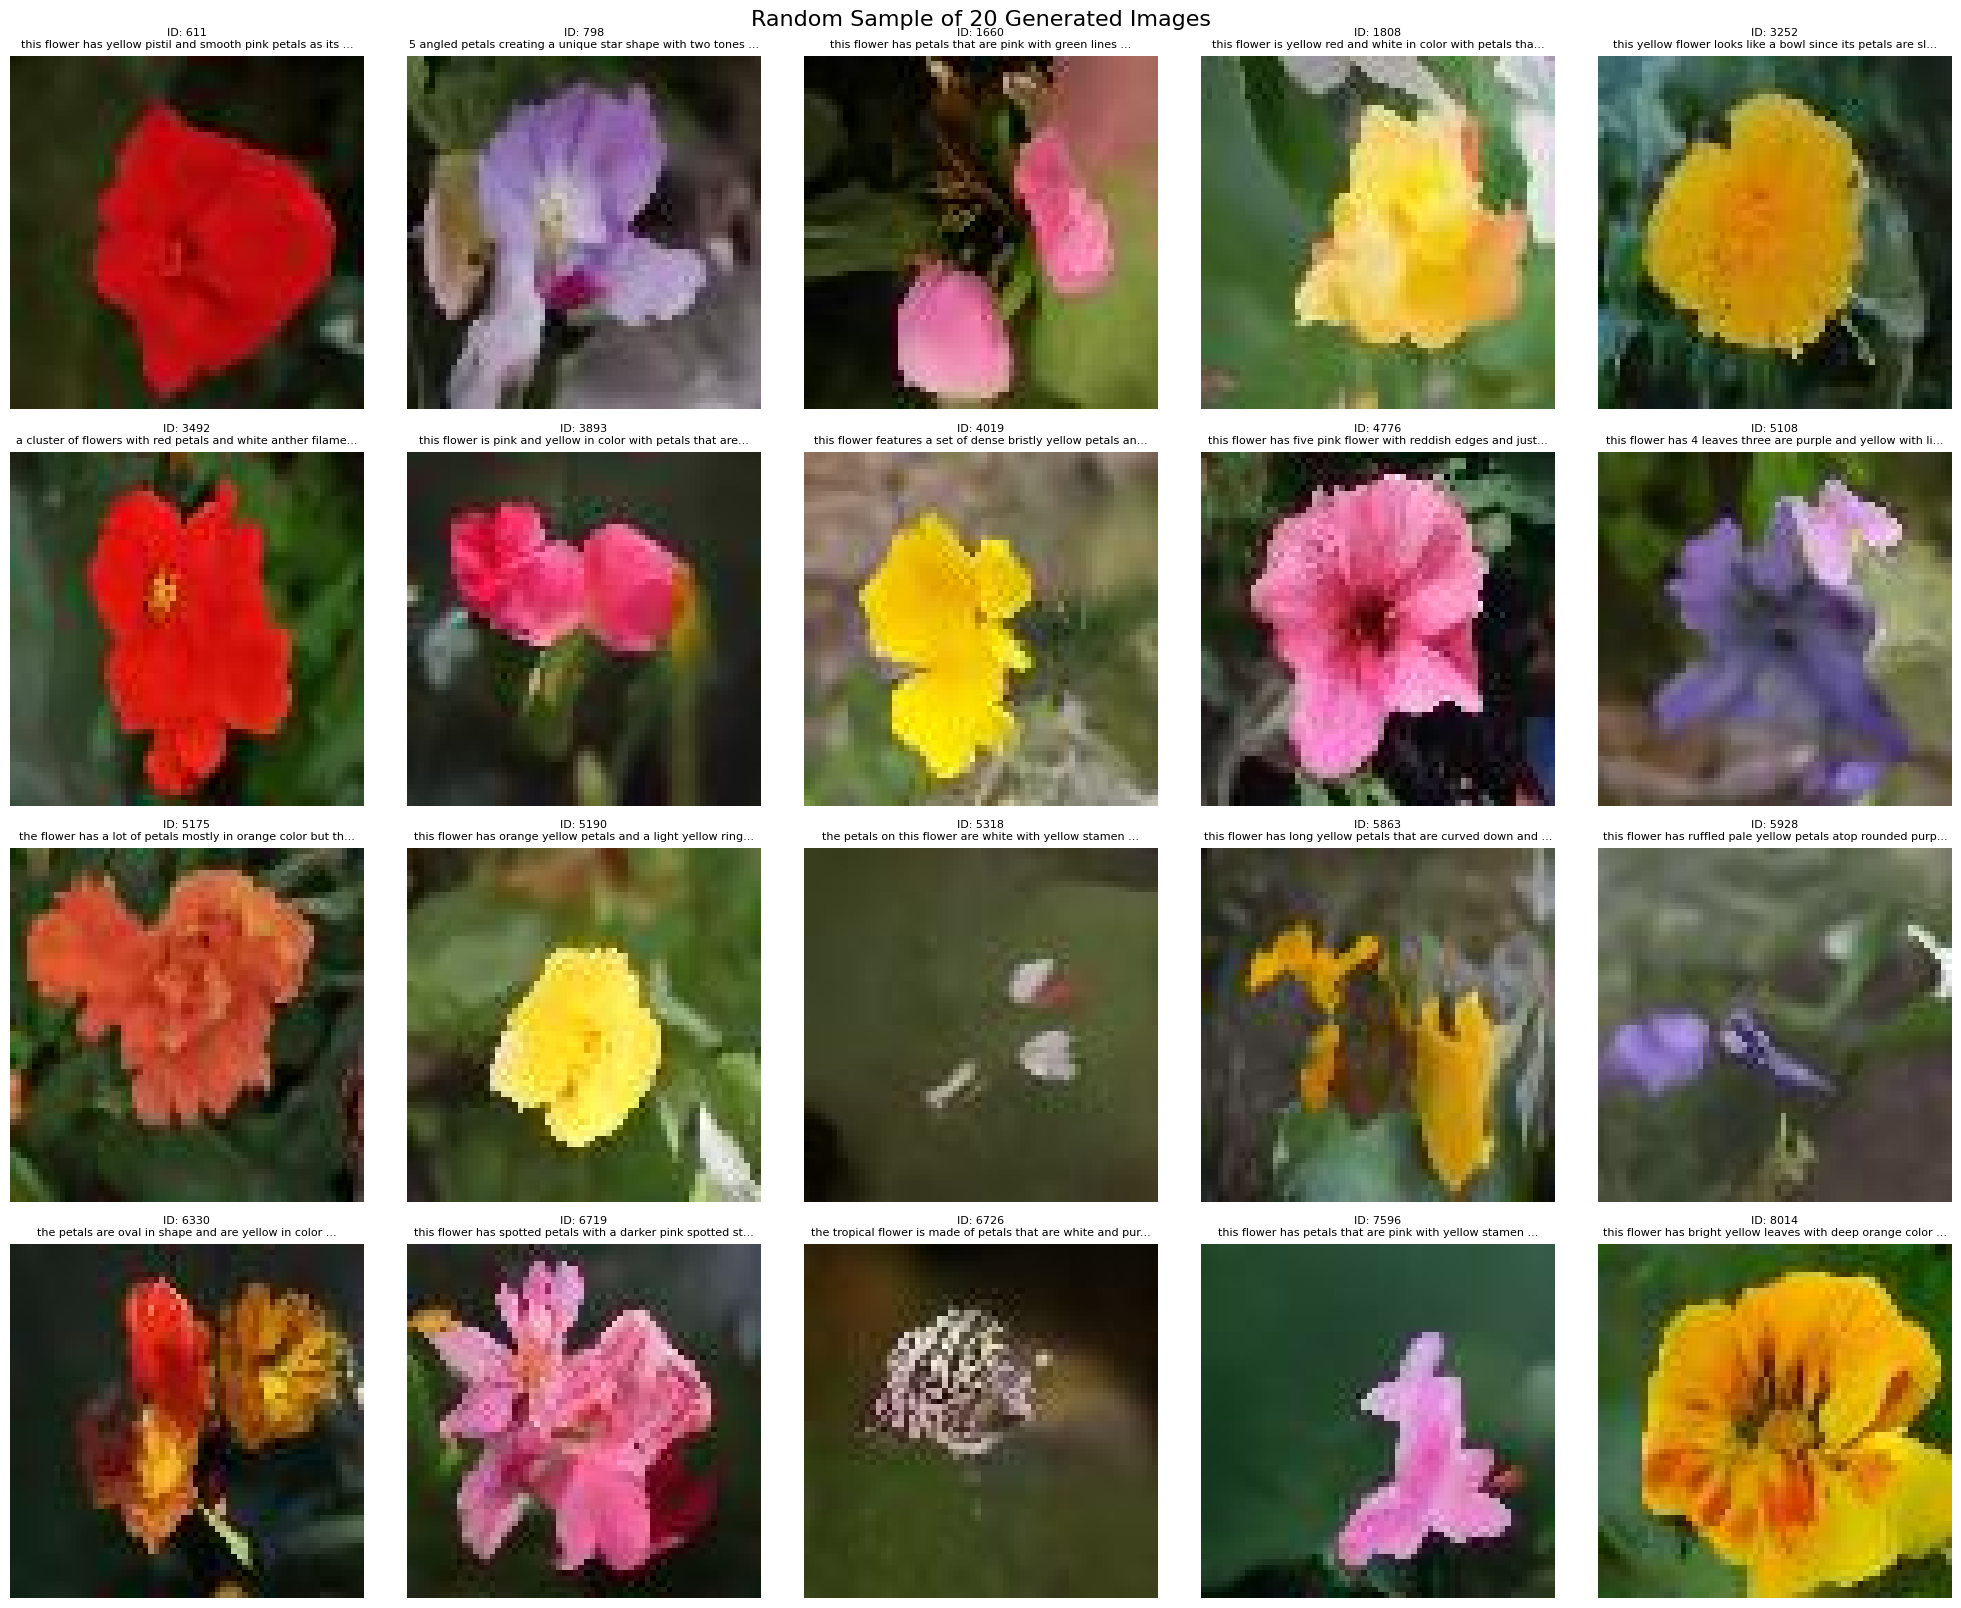


Total generated images: 819
Images directory: ./runs/20251129-181703/inference


In [ ]:
# Visualize 20 random generated images with their captions
import glob

inference_dir = testing_inference_dir
# Load test data
data = pd.read_pickle(BASE_PATH + '/dataset/testData.pkl')
test_captions = data['Captions'].values
test_ids = data['ID'].values

# Get all generated images from the current inference directory
image_files = sorted(glob.glob(inference_dir + '/inference_*.jpg'))

if len(image_files) == 0:
    print(f'⚠ No images found in {inference_dir}')
    print('Please run the inference cell first!')
else:
    # Randomly sample 20 images
    np.random.seed(42)  # For reproducibility
    num_samples = min(20, len(image_files))
    sample_indices = np.random.choice(len(image_files), size=num_samples, replace=False)
    sample_files = [image_files[i] for i in sorted(sample_indices)]

    # Create 4x5 grid
    fig, axes = plt.subplots(4, 5, figsize=(20, 16))
    axes = axes.flatten()

    for idx, img_path in enumerate(sample_files):
        # Extract image ID from filename
        img_id = int(Path(img_path).stem.split('_')[1])

        # Find caption
        caption_idx = np.where(test_ids == img_id)[0][0]
        caption_ids = test_captions[caption_idx]

        # Decode caption
        caption_text = ''
        for word_id in caption_ids:
            word = id2word_dict[str(word_id)]
            if word != '<PAD>':
                caption_text += word + ' '

        # Load and display image
        img = plt.imread(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f'ID: {img_id}\n{caption_text[:60]}...', fontsize=8)
        axes[idx].axis('off')

    # Hide unused subplots if less than 20 images
    for idx in range(num_samples, 20):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.suptitle(f'Random Sample of {num_samples} Generated Images', fontsize=16, y=1.002)
    plt.show()

    print(f'\nTotal generated images: {len(image_files)}')
    print(f'Images directory: {inference_dir}')